<a href="https://colab.research.google.com/github/LUMII-AILab/NLP_Course/blob/main/notebooks/NaiveBayes.ipynb" target="_new"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [37]:
!wget https://github.com/AndrejsPetrovs/NLP_hw/blob/main/dev.tsv
!wget https://github.com/AndrejsPetrovs/NLP_hw/blob/main/ekman_mapping.json
!wget https://github.com/AndrejsPetrovs/NLP_hw/blob/main/emotions.txt
!wget https://github.com/AndrejsPetrovs/NLP_hw/blob/main/stoplist.txt
!wget https://github.com/AndrejsPetrovs/NLP_hw/blob/main/test.tsv
!wget https://github.com/AndrejsPetrovs/NLP_hw/blob/main/train.tsv

--2024-06-10 00:09:10--  https://github.com/AndrejsPetrovs/NLP_hw/blob/main/dev.tsv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dev.tsv.2’

dev.tsv.2               [ <=>                ] 623.03K  --.-KB/s    in 0.1s    

2024-06-10 00:09:10 (4.91 MB/s) - ‘dev.tsv.2’ saved [637979]

--2024-06-10 00:09:10--  https://github.com/AndrejsPetrovs/NLP_hw/blob/main/ekman_mapping.json
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘ekman_mapping.json.1’

ekman_mapping.json.     [ <=>                ] 288.42K  --.-KB/s    in 0.1s    

2024-06-10 00:09:11 (2.22 MB/s) - ‘ekman_mapping.json.1’ saved [295347]

--2024-06-10 00:09:11--  https://github.com/AndrejsPetrovs/NLP_hw/b

In [2]:
!pip install nltk
!pip install scikit-learn
!pip install seaborn

In [3]:
import nltk
nltk.download('punkt')

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy

import seaborn
import matplotlib.pyplot as mplot

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import re
import os
import sys
import pickle
import datetime
import json
import csv
from nltk.tokenize import sent_tokenize, word_tokenize

In [35]:

def emoteToNum(emotion):
    with open("emotions.txt") as f:
        rown=0
        for row in f:
            if(row[-1]=="\n"):
                row=row[:-1]
            if row==emotion:
                return rown
            rown+=1
        return -1


targets=["dev.tsv", "test.tsv", "train.tsv"]
targetsout=["dev2.tsv", "test2.tsv", "train2.tsv"]


mappingfile="ekman_mapping.json"
with open(mappingfile) as f:
    mappingwords=json.load(f)
mapping=[0]*28
mapping[27]=6

classes=[""]*7
classes[6]="neutral"
wnum=0
for w in mappingwords:
    classes[wnum]=w
    for w2 in mappingwords[w]:
        mapping[emoteToNum(w2)]=wnum
    wnum+=1

for i in range(len(classes)):
  print(f"{i}: {classes[i]}")

alltxt = ""

for i in range(len(targets)):
    with open(targets[i], encoding="utf8") as fin:
        with open(targetsout[i], "w", encoding="utf8") as fout:
            reader = csv.reader(fin, delimiter="\t")
            writer = csv.writer(fout, delimiter="\t", lineterminator="\n")
            for row in reader:
                txt = row[0]
                if i==1:
                    alltxt+=(txt+" ")
                tags = row[1].split(",")
                for j in range(len(tags)):
                    tags[j]=mapping[int(tags[j])]
                tags=list(set(tags))
                for tag in tags:
                    writer.writerow([str(tag), txt])

allsents = sent_tokenize(alltxt)
freqlist = {}
for s in allsents:
    s = re.sub(r'\s+', ' ', s.strip())
    w = word_tokenize(s)
    for word in w:
        word=word.lower()
        if word not in freqlist:
            freqlist[word]=0
        freqlist[word]+=1


freqlistfile = "freqlist.tsv"


with open(freqlistfile, "w", encoding="utf8") as f:
    writer = csv.writer(f, delimiter="\t", lineterminator="\n")
    for word in freqlist.keys():
        writer.writerow([str(freqlist[word]), word])



0: anger
1: disgust
2: fear
3: joy
4: sadness
5: surprise
6: neutral


## Text preprocessing

In [34]:
def initialise(stop_txt, freq_tsv):
	global STOPLIST
	STOPLIST = set()

	with open(stop_txt) as txt:
		for word in txt:
			STOPLIST.add(normalize_text(word.strip()))

	print("[I] Word stoplist is read:", len(STOPLIST))

	global WHITELIST
	WHITELIST = set()

	with open(freq_tsv) as tsv:
		for entry in tsv:
			freq, word = entry.strip().split("\t")

			if int(freq) < 5:
				# Ignore the long tail: most words occure less than N times
				continue

			WHITELIST.add(normalize_text(word))

	print("[I] Word whitelist is read:", len(WHITELIST))

In [7]:
def normalize_text(text):
	text = text.lower()
	text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text) # e-mail addresses
	text = re.sub(r'https?://[A-Za-z0-9./-]+|www\.[A-Za-z0-9./-]+', '', text)				# URLs
	text = re.sub(r'\d+', "100", text)																					    # numbers

	return text.strip()


def normalize_vector(vector):
	words = list(vector.keys())

	for w in words:
		if w in STOPLIST or len(w) == 1 or w not in WHITELIST:
			vector.pop(w)

	return vector


def vectorize_text(text):
	return normalize_vector({word: True for word in nltk.word_tokenize(normalize_text(text))})

In [8]:
def read_data(file):
	data_set = {}  # topic => samples

	with open(file) as data:
		for entry in data:
			topic, text = entry.strip().split("\t")

			sub_set = []
			if topic in data_set:
				sub_set = data_set[topic]

			sub_set.append((vectorize_text(text), topic))
			data_set[topic] = sub_set

	return data_set


def join_data(data_set):
	union = []

	for cat in data_set:
		union += data_set[cat]

	return union

## Experimentation & evaluation

In [9]:
# Separate training and test data passed
def cross_validate2(train_data_set, test_data_set):
    global LABELS
    LABELS = []

    # Initialize data containers
    train_data = numpy.array([])
    test_data = numpy.array([])

    # Combine training data from all categories
    for cat in train_data_set:
        LABELS.append(cat)
        if len(train_data) > 0:
            train_data = numpy.append(train_data, train_data_set[cat], axis=0)
        else:
            train_data = train_data_set[cat]

    # Combine test data from all categories
    for cat in test_data_set:
        if len(test_data) > 0:
            test_data = numpy.append(test_data, test_data_set[cat], axis=0)
        else:
            test_data = test_data_set[cat]

    # Naive Bayes classifier: training and evaluation
    nb = nltk.NaiveBayesClassifier.train(train_data)
    validation_accuracy = nltk.classify.accuracy(nb, test_data)

    validations = [validation_accuracy]
    gold_result = []
    silver_result = []

    for t in test_data:
        gold_result.append(t[1])
        silver_result.append(nb.classify(t[0]))

    return (validations, gold_result, silver_result)

In [10]:
def run_validation2(train_data_path, test_data_path):
		print("Cross-validation:\n")

		start_time = datetime.datetime.now().replace(microsecond=0)

		# Run k-fold cross-validation
		validations, gold, silver = cross_validate2(read_data(train_data_path), read_data(test_data_path))

		# Print the average accuracy: for each cross-validation step, and overall
		for step in validations:
				print("{0:.2f}  ".format(step), end='')
		print("{0:.0%}".format(numpy.mean(validations)))

		end_time = datetime.datetime.now().replace(microsecond=0)
		print("\nTotal validation time:", end_time - start_time, "\n")

		# Print an evaluation report
		print(classification_report(gold, silver))

		# Print a fancy confusion matrix
		matrix = confusion_matrix(gold, silver)
		seaborn.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS)
		mplot.xticks(rotation=90)
		mplot.show()
		# cf. print(nltk.ConfusionMatrix(gold_total, silver_total))

## Training for production

In [12]:
def run_training(data_path, verbose):
		print("[I] Training an NB classifier...")
		start_time = datetime.datetime.now().replace(microsecond=0)

		# TRAINING
		# The final (production) model is trained by using all available data (train+test)
		nb = nltk.NaiveBayesClassifier.train(join_data(read_data(data_path)))

		end_time = datetime.datetime.now().replace(microsecond=0)
		print("[I] Training time:", end_time - start_time)

		if verbose:
				nb.show_most_informative_features(n=10) # Try with n=100

		# Save the model for later use
		with open("nb_classifier.pickle", "wb") as dmp:
				pickle.dump(nb, dmp)
				print("[I] NB classifier stored in a file")

## The inference part

In [13]:
def run_inference():
		# Load the pre-trained model
		with open("nb_classifier.pickle", "rb") as dmp:
				nb = pickle.load(dmp)
				print("[I] NB classifier loaded from a file")

		while True:
				text = input("\nEnter a text to classify: ")
				if len(text) == 0: break

				# Extract text features for classification
				text_feat = vectorize_text(text)
				print("\nFeatures:", text_feat.keys(), "\n")

				# INFERENCE
				# Calculate a probability distribution over the classes
				prob_dist = nb.prob_classify(text_feat)

				# Return the probability distribution
				for label in prob_dist.samples():
						print("{0}: {1:.3f}".format(classes[int(label)], prob_dist.prob(label)))

				# Return the most probable class
				print("\nPrediction:", classes[int(prob_dist.max())])

## Execution

In [32]:
# Initialise the stopword and word frequency lists
initialise('stoplist.txt', 'freqlist.tsv')

[I] Word stoplist is read: 189
[I] Word whitelist is read: 1766


Cross-validation:

0.51  51%

Total validation time: 0:00:14 

              precision    recall  f1-score   support

           0       0.44      0.36      0.40       726
           1       0.30      0.41      0.35       123
           2       0.38      0.51      0.43        98
           3       0.56      0.80      0.66      2104
           4       0.41      0.45      0.43       379
           5       0.39      0.24      0.30       677
           6       0.56      0.36      0.44      1787

    accuracy                           0.51      5894
   macro avg       0.43      0.45      0.43      5894
weighted avg       0.51      0.51      0.49      5894



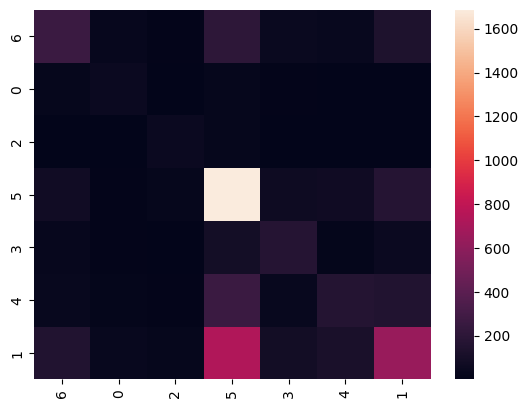

In [33]:
run_validation2("train2.tsv", "test2.tsv")

In [35]:
# Train and save the final model
run_training("train2.tsv", True) # True=verbose

[I] Training an NB classifier...
[I] Training time: 0:00:12
Most Informative Features
                   scary = True                2 : 0      =    237.9 : 1.0
              disgusting = True                1 : 3      =    225.1 : 1.0
                   awful = True                1 : 6      =    206.8 : 1.0
                  scared = True                2 : 6      =    170.8 : 1.0
                 worried = True                2 : 6      =    140.5 : 1.0
                  afraid = True                2 : 0      =    117.3 : 1.0
                terrible = True                2 : 6      =     86.2 : 1.0
                   sorry = True                4 : 6      =     79.2 : 1.0
                realized = True                5 : 6      =     75.1 : 1.0
                 awesome = True                3 : 6      =     70.1 : 1.0
[I] NB classifier stored in a file


In [39]:
# Run the pre-trained model
run_inference()

[I] NB classifier loaded from a file

Enter a text to classify: 100%! Congrats on your job too!

Features: dict_keys(['100', 'congrats', 'job']) 

neutral: 0.025
anger: 0.016
fear: 0.001
surprise: 0.036
joy: 0.894
sadness: 0.027
disgust: 0.000

Prediction: joy

Enter a text to classify: Again, overall, not just for me. 

Features: dict_keys([]) 

neutral: 0.300
anger: 0.118
fear: 0.015
surprise: 0.113
joy: 0.368
sadness: 0.069
disgust: 0.017

Prediction: joy

Enter a text to classify: I’m so sorry 🤪

Features: dict_keys(['sorry']) 

neutral: 0.035
anger: 0.044
fear: 0.012
surprise: 0.070
joy: 0.197
sadness: 0.629
disgust: 0.014

Prediction: sadness


KeyboardInterrupt: Interrupted by user